In [1]:
#load packages
import pandas as pd #collection of functions for data processing and analysis modeled after R dataframes with SQL like features
import matplotlib as mpl #collection of fun for scientific and publication-ready visualization
import numpy as np #foundational package for scientific computing
import scipy as sp #collection of functions for scientific computing and advance mathematics
import IPython
from IPython import display #pretty printing of dataframes in Jupyter notebook
import sklearn #collection of machine learning algorithms)

from scipy.stats import norm, skew #for some statistics
from scipy import stats

#misc libraries
import random
import time

#ignore warnings
import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings('always')

#Common Model Algorithms
from sklearn import svm, tree, linear_model, neighbors, naive_bayes, ensemble, discriminant_analysis, gaussian_process
from xgboost import XGBClassifier

#Common Model Helpers
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn import feature_selection
from sklearn import model_selection
from sklearn import metrics
from sklearn.utils import shuffle
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectFromModel

from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score

from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression

#Visualization
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
import seaborn as sns
from pandas.tools.plotting import scatter_matrix

/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc size changed, may indicate binary incompatibility. Expected 216, got 192
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: ImportWarning: can't resolve package from __spec__ or __package__, falling back on __name__ and __path__
  return f(*args, **kwds)
/opt/conda/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.ufunc s

In [2]:
xlsx = pd.ExcelFile("../input/uc-assignment-slots.xlsx")

train = xlsx.parse(2) ## train_data
test = xlsx.parse(3) ## test_data

In [3]:
print(train.shape)
print(test.shape)

(618524, 8)
(172082, 8)


# event_time

In [4]:
train["hour"] = [t.hour for t in pd.DatetimeIndex(train.event_time)]
train["day"] = [t.dayofweek for t in pd.DatetimeIndex(train.event_time)]
train["month"] = [t.month for t in pd.DatetimeIndex(train.event_time)]
train['year'] = [t.year for t in pd.DatetimeIndex(train.event_time)]
train['year'] = train['year'].map({2018:0, 2019:1})
train['month'] = train['month'].map({12:0, 1:1})

train.drop('event_time', axis=1, inplace= True)
train.sample(5)

,record_id,city_key,weekday,category_key,rptcatg,req_id,session_group,hour,day,month,year
224327,5c17462b92d98d230028b098,city_ahmedabad_v2,weekday,salon_at_home,Salon at Home,NaN,2233,12,0,0,0
573796,5c34e47e0875082400fbf641,city_pune_v2,weekday,massage_for_men,Massage for Men,NaN,33,23,1,1,1
328040,5c1df7a9ba0b05230048e878,city_bangalore_v2,saturday,massage_for_men,Massage for Men,5c1df89cd6fe1e2300f4ffd3,2023,14,5,0,0
411762,5c32f265d3d13025000b1cf7,city_mumbai_v2,weekday,professional_bathroom_cleaning,Cleaning - Other,NaN,2233,12,0,1,1
219854,5c230c7d15646423008eb6e1,city_delhi_v2,weekday,salon_at_home,Salon at Home,NaN,2233,10,2,0,0


In [5]:
test["hour"] = [t.hour for t in pd.DatetimeIndex(test.event_time)]
test["day"] = [t.dayofweek for t in pd.DatetimeIndex(test.event_time)]
test["month"] = [t.month for t in pd.DatetimeIndex(test.event_time)]
test['year'] = [t.year for t in pd.DatetimeIndex(test.event_time)]
test['year'] = test['year'].map({2018:0, 2019:1})
test['month'] = test['month'].map({12:0, 1:1})

test.drop('event_time', axis=1, inplace= True)
test.sample(5)

,record_id,city_key,weekday,category_key,rptcatg,req_id,session_group,hour,day,month,year
108305,5c41f8aab74c5324000ded63,city_ahmedabad_v2,friday,salon_at_home,Salon at Home,5c41f8e06f986824008f3995,33,21,4,1,1
77120,5c40563ea1c8982300061981,city_delhi_v2,weekday,salon_at_home,Salon at Home,NaN,1012,15,3,1,1
124271,5c42cdd0a1638d2600c1cae5,city_pune_v2,saturday,salon_at_home,Salon at Home,NaN,2233,12,5,1,1
109537,5c420654227e5824004bba37,city_mumbai_v2,friday,professional_home_cleaning,Full Home Cleaning,5c420b5f8d7ad52600769bbd,20,22,4,1,1
83882,5c40a44ae6036e2500827e2c,city_hyderabad_v2,weekday,massage_for_men,Massage for Men,NaN,30,21,3,1,1


In [6]:
train.describe(include= 'all')

,record_id,city_key,weekday,category_key,rptcatg,req_id,session_group,hour,day,month,year
count,618524,618524,618524,618524,618524,281732,618524.000000,618524.000000,618524.000000,618524.000000,618524.000000
unique,618524,10,4,19,9,281720,NaN,NaN,NaN,NaN,NaN
top,5c1db56a79114e2300ad3d62,city_delhi_v2,weekday,salon_at_home,Salon at Home,5c2a630f8a5ecd240022476b,NaN,NaN,NaN,NaN,NaN
freq,1,143839,338431,272392,272392,2,NaN,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,NaN,NaN,NaN,1753.105841,13.661331,3.064819,0.394062,0.394062
std,NaN,NaN,NaN,NaN,NaN,NaN,1149.746184,5.158253,1.974106,0.488649,0.488649
min,NaN,NaN,NaN,NaN,NaN,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
25%,NaN,NaN,NaN,NaN,NaN,NaN,1033.000000,10.000000,1.000000,0.000000,0.000000
50%,NaN,NaN,NaN,NaN,NaN,NaN,2233.000000,13.000000,3.000000,0.000000,0.000000
75%,NaN,NaN,NaN,NaN,NaN,NaN,2233.000000,17.000000,5.000000,1.000000,1.000000


In [7]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 172082 entries, 0 to 172081
Data columns (total 11 columns):
record_id        172082 non-null object
city_key         172082 non-null object
weekday          172082 non-null object
category_key     172082 non-null object
rptcatg          172082 non-null object
req_id           78738 non-null object
session_group    172082 non-null int64
hour             172082 non-null int64
day              172082 non-null int64
month            172082 non-null int64
year             172082 non-null int64
dtypes: int64(5), object(6)
memory usage: 14.4+ MB


# req_id

In [8]:
train.req_id.value_counts().head(15)

5c2a630f8a5ecd240022476b    2
5c1be07342fb432300cfa4e2    2
5c1be1b744288724007a1f6a    2
5c1be065b48f05230000071f    2
5c1be0226eaf2c2300ebc830    2
5c2a629eea56562700c42851    2
5c1bdfbfef671024001a29c3    2
5c1be2ffa08390260045e009    2
5c1be0c16dfd5525002df03a    2
5c2a638601cd922600ccb72e    2
5c1be4d8a08390260045e159    2
5c1be3064415802500b4effe    2
5c298879544e962400787193    1
5c1a00b7be6f2f25003d19fb    1
5c23ac73f1cba02600f83f12    1
Name: req_id, dtype: int64

That's strange req_id is repeted only in the train dataset and for only very few of the times. Let's see the data   

In [9]:
train.loc[train['req_id'] == '5c1be07342fb432300cfa4e2']

,record_id,city_key,weekday,category_key,rptcatg,req_id,session_group,hour,day,month,year
23966,5c1bdee88be291230003881b,city_hyderabad_v2,weekday,salon_at_home,Salon at Home,5c1be07342fb432300cfa4e2,33,23,3,0,0
157067,5c1be0508584a72600e6612f,city_hyderabad_v2,friday,salon_at_home,Salon at Home,5c1be07342fb432300cfa4e2,3333,0,4,0,0


they are diffrent values... 

In [10]:
values = ['5c1be07342fb432300cfa4e2','5c1be4d8a08390260045e159','5c2a638601cd922600ccb72e','5c1be1b744288724007a1f6a','5c1be3064415802500b4effe','5c1be0c16dfd5525002df03a',
       '5c1bdfbfef671024001a29c3','5c2a629eea56562700c42851','5c1be2ffa08390260045e009','5c2a630f8a5ecd240022476b','5c1be0226eaf2c2300ebc830','5c1be065b48f05230000071f']
for val in values:
    train = train[train['req_id'] != val]


In [11]:
test.req_id.value_counts().head(5)

5c4350e8014e982400eb6743    1
5c401ac8a1015c2400610c40    1
5c40c0dffe54c926007dd0d3    1
5c41ae951894d524008fc4d5    1
5c418e9cf35674250035a297    1
Name: req_id, dtype: int64

In [12]:
train['has_req_id'] = 0
train.loc[train['req_id'].isnull() == False, 'has_req_id'] = 1
train.drop('req_id', axis=1, inplace = True)

test['has_req_id'] = 0
test.loc[test['req_id'].isnull() == False, 'has_req_id'] = 1
test.drop('req_id', axis=1, inplace = True)

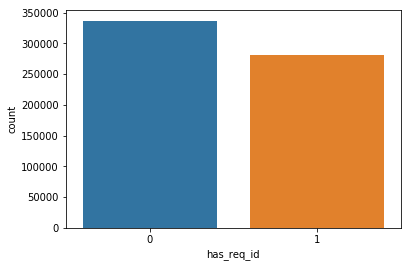

In [13]:
sns.countplot(x="has_req_id", data=train)

    Good, we are working with a balanced dataset.

Let's see the interrelation bet the features once using a heat map 

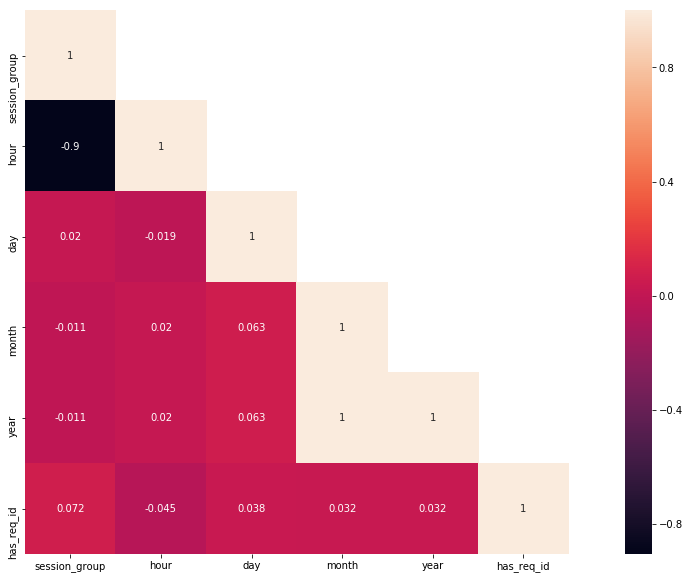

In [14]:
cor_mat= train[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(20,10)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

# city key

In [15]:
train.city_key.value_counts()

city_delhi_v2         143831
city_mumbai_v2        120376
city_bangalore_v2     104628
city_hyderabad_v2      84428
city_pune_v2           63610
city_kolkata_v2        37240
city_chennai_v2        36687
city_ahmedabad_v2      23333
city_chandigarh_v2      2331
city_jaipur_v2          2036
Name: city_key, dtype: int64

In [16]:
train['city_key'] = train['city_key'].map(lambda x: str(x)[:-3])
train['city_key'] = train['city_key'].map(lambda x: str(x)[5:])

test['city_key'] = test['city_key'].map(lambda x: str(x)[:-3])
test['city_key'] = test['city_key'].map(lambda x: str(x)[5:])

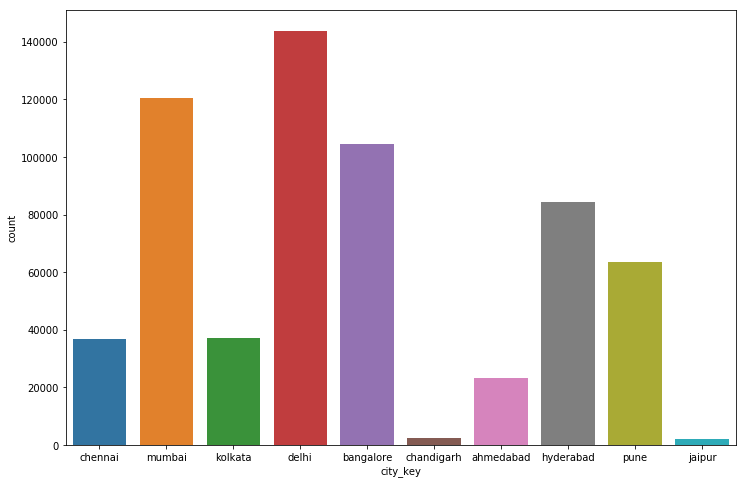

In [17]:
plt.figure(figsize = (12,8))
sns.countplot(train['city_key'])
plt.show()

So, delhi has highest number of customers...that's obvious
Let's look at which city has more request and which city has more acceptance

has_req_id      0      1
city_key                
ahmedabad   12875  10458
bangalore   58381  46247
chandigarh   1422    909
chennai     19134  17553
delhi       73949  69882
hyderabad   47559  36869
jaipur       1370    666
kolkata     20966  16274
mumbai      66353  54023
pune        34783  28827


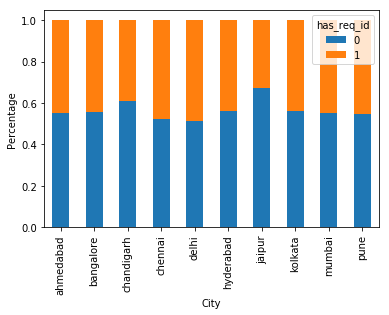

In [18]:
tab = pd.crosstab(train['city_key'],train['has_req_id'])
print(tab)

dummy = tab.div(tab.sum(1).astype(float), axis = 0).plot(kind = "bar", stacked = True)
dummy = plt.xlabel("City")
dummy = plt.ylabel("Percentage")

So,Delhi and Cheenai has higher placed request among all the cities while Jaipur has the least.

In [19]:
dummy=pd.get_dummies(train['city_key'],prefix='city_')
train=pd.concat([train,dummy],axis=1)
train.drop('city_key', axis=1, inplace= True)

dummy=pd.get_dummies(test['city_key'],prefix='city_')
test=pd.concat([test,dummy],axis=1)
test.drop('city_key', axis=1, inplace= True)

# weekday

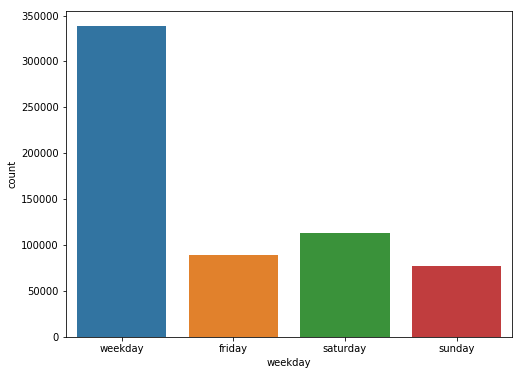

In [20]:
plt.figure(figsize = (8,6))
sns.countplot(train['weekday'])
plt.show()

there is more visit on saturday compared to sunday or friday
let's see relation between city and weekday.

has_req_id       0       1
weekday                   
friday       45881   43555
saturday     57902   55386
sunday       42378   34982
weekday     190631  147785


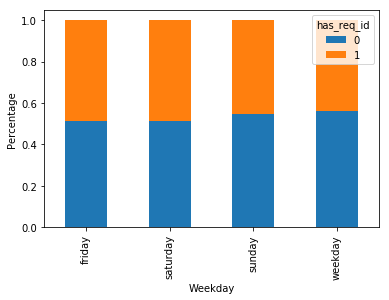

In [21]:
tab = pd.crosstab(train['weekday'],train['has_req_id'])
print(tab)

dummy = tab.div(tab.sum(1).astype(float), axis = 0).plot(kind = "bar", stacked = True)
dummy = plt.xlabel("Weekday")
dummy = plt.ylabel("Percentage")

so conversion rate of session is somewhat similar for all the days

In [22]:
dummy=pd.get_dummies(train['weekday'],prefix='day_')
train=pd.concat([train,dummy],axis=1)
train.drop('weekday', axis=1, inplace= True)

dummy=pd.get_dummies(test['weekday'],prefix='day_')
test=pd.concat([test,dummy],axis=1)
test.drop('weekday', axis=1, inplace= True)

# category_key

In [23]:
train.rptcatg.value_counts()

Salon at Home         272376
EPC                   126792
Cleaning - Other       55246
Massage for Men        52302
Appliance Repair       46252
Spa for Women          39697
Full Home Cleaning     15171
Pest Control            9107
Mens Grooming           1557
Name: rptcatg, dtype: int64

Salon at home has higher request

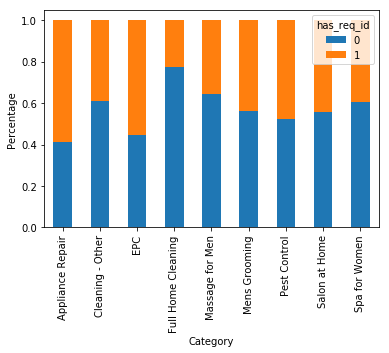

In [24]:
tab = pd.crosstab(train['rptcatg'],train['has_req_id'])
dummy = tab.div(tab.sum(1).astype(float), axis = 0).plot(kind = "bar", stacked = True)
dummy = plt.xlabel("Category")
dummy = plt.ylabel("Percentage")

Appliance repair is highest while Home cleaning is lowest

In [25]:
dummy=pd.get_dummies(train['rptcatg'],prefix='cat_')
train=pd.concat([train,dummy],axis=1)
train.drop('rptcatg', axis=1, inplace= True)

dummy=pd.get_dummies(test['rptcatg'],prefix='cat_')
test=pd.concat([test,dummy],axis=1)
test.drop('rptcatg', axis=1, inplace= True)

In [26]:
train.drop('category_key', axis=1, inplace= True)
test.drop('category_key', axis=1, inplace= True)

# hour

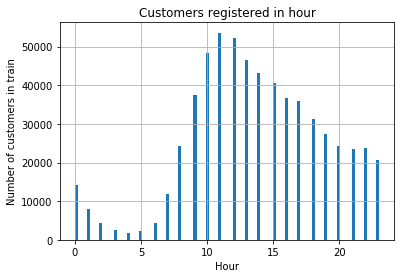

In [27]:
train.hour.hist(bins=100)
plt.xlabel('Hour')
plt.ylabel('Number of customers in train')
plt.title('Customers registered in hour')
plt.show()

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


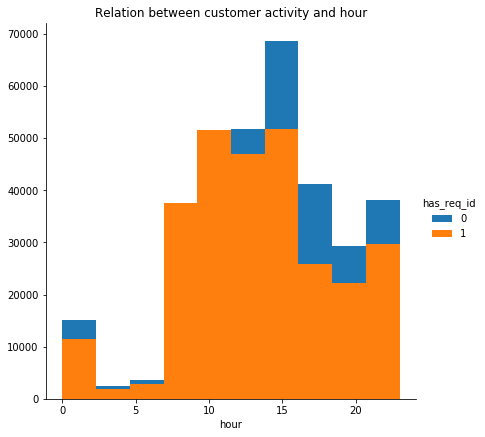

In [28]:
sns.FacetGrid(train, hue="has_req_id", size=6).map(plt.hist, "hour").add_legend()
plt.title('Relation between customer activity and hour')
plt.show()

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumva

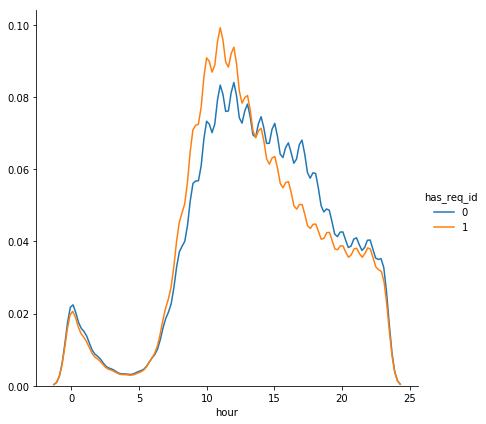

In [29]:
sns.FacetGrid(train, hue="has_req_id", size=6).map(sns.kdeplot, "hour").add_legend()

# day

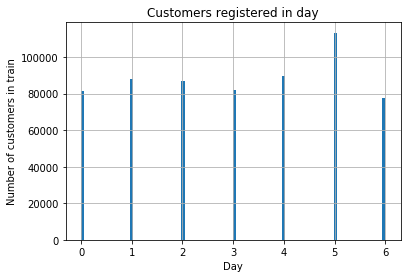

In [30]:
train.day.hist(bins=100)
plt.xlabel('Day')
plt.ylabel('Number of customers in train')
plt.title('Customers registered in day')
plt.show()

So, saturday has more customer

/opt/conda/lib/python3.6/site-packages/seaborn/axisgrid.py:230: UserWarning: The `size` paramter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumva

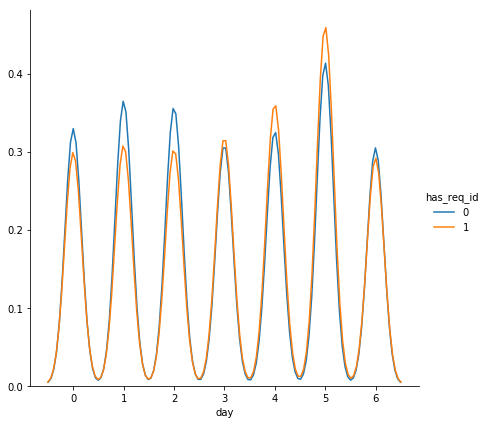

In [31]:
sns.FacetGrid(train, hue="has_req_id", size=6).map(sns.kdeplot, "day").add_legend()

Friday and Saturday has more probability of conversion while mon,tue and wed has least

# session_group

In [32]:
train.session_group.value_counts().head(15)

2233    204014
33      115045
3333     83556
1133     46308
1033     33680
3233     26337
2033     16920
23       15266
2133     13368
2023      4134
2022      4129
22        4084
1022      3512
3         3225
3033      3156
Name: session_group, dtype: int64

Session group need to be 4 digit but here we can see that it contains 3,2,1 digits too.
For 3,2,1 it misses trailing 0 so,let's add 0.

And creating new features by splitting it into seperate values

In [33]:
train.session_group = (train.session_group.astype(str).str.zfill(4))
train[['D0_possible','D0_shown','D1_shown','D2_shown']] = train['session_group'].astype(str).apply(lambda x: pd.Series(list(x))).astype(int)

test.session_group = (test.session_group.astype(str).str.zfill(4))
test[['D0_possible','D0_shown','D1_shown','D2_shown']] = test['session_group'].astype(str).apply(lambda x: pd.Series(list(x))).astype(int)

D1 possible and D2 possible are always 3 so it's not useful

In [34]:
train.drop('session_group',axis=1,inplace= True)
test.drop('session_group',axis=1,inplace= True)

# slot

Let's create 1 new feature for slot

In [35]:
def slot_method(row):
    if row['hour']>=0 and row['hour']<=10:
        return 1
    elif row['hour']>10 and row['hour']<=12:
        return 2
    elif row['hour']>12 and row['hour']<=15:
        return 3
    elif row['hour']>15 and row['hour']<=18:
        return 4
    elif row['hour']>18 and row['hour']<=20:
        return 5
    else:
        return 6

train['slot'] = 0    
train['slot'] = train.apply(lambda row: slot_method(row), axis=1)

test['slot'] = 0    
test['slot'] = test.apply(lambda row: slot_method(row), axis=1)

Let's finally look our dataset

In [36]:
print("Train dataset (rows, cols):",train.shape, "\nTest dataset (rows, cols):",test.shape)

Train dataset (rows, cols): (618500, 34) 
Test dataset (rows, cols): (172082, 34)


Now, let's have a look on our new features

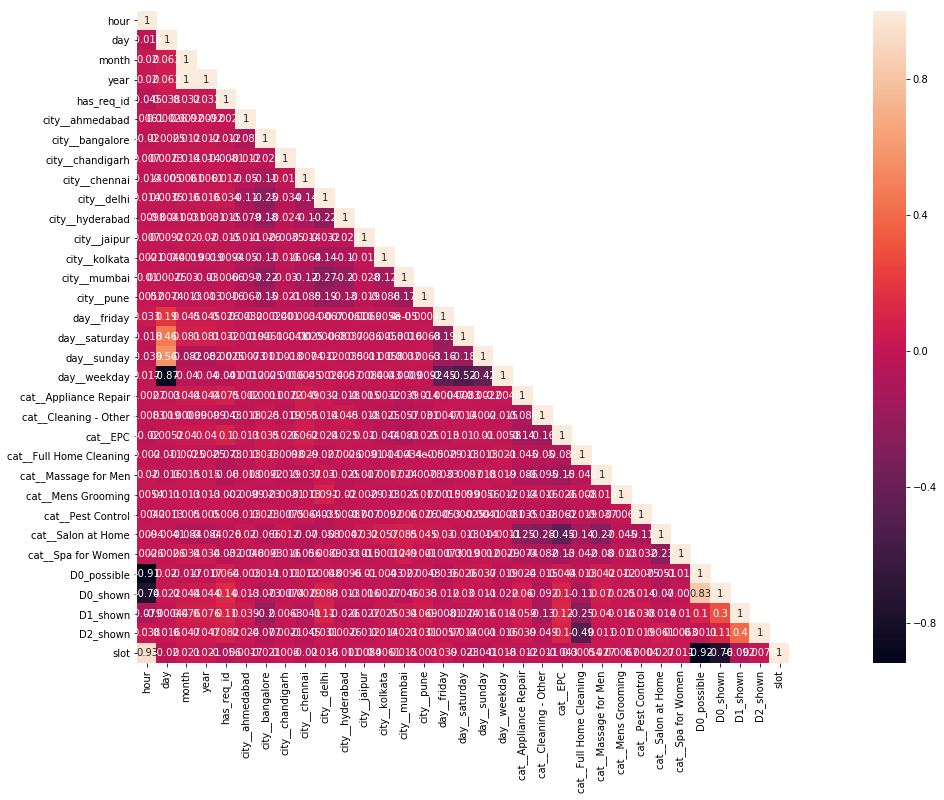

In [37]:
cor_mat= train[:].corr()
mask = np.array(cor_mat)
mask[np.tril_indices_from(mask)] = False
fig=plt.gcf()
fig.set_size_inches(30,12)
sns.heatmap(data=cor_mat,mask=mask,square=True,annot=True,cbar=True)

In [38]:
# only important correlations and not auto-correlations
threshold = 0.75
important_corrs = (cor_mat[abs(cor_mat) > threshold][cor_mat != 1.0]).unstack().dropna().to_dict()
unique_important_corrs = pd.DataFrame(
    list(set([(tuple(sorted(key)), important_corrs[key]) \
    for key in important_corrs])), columns=['attribute pair', 'correlation'])
# sorted by absolute value
unique_important_corrs = unique_important_corrs.ix[
    abs(unique_important_corrs['correlation']).argsort()[::-1]]
unique_important_corrs

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:8: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  


,attribute pair,correlation
2,"(hour, slot)",0.932901
3,"(D0_possible, slot)",-0.916827
5,"(D0_possible, hour)",-0.906603
1,"(day, day__weekday)",-0.871922
4,"(D0_possible, D0_shown)",0.827454
0,"(D0_shown, slot)",-0.756600


hour and slot are highly corelated, creating new feature slot didn't help us, so let's drop this

In [39]:
 train.drop('slot',axis = 1 ,inplace = True)
test.drop('slot',axis = 1 ,inplace = True)

Let's visualize the plots of these variables with strong correlations.

To show the pairs of values that are correlated we use pairplot. Before representing the pairs, we subsample the data, using only 2% in the sample.

/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead o

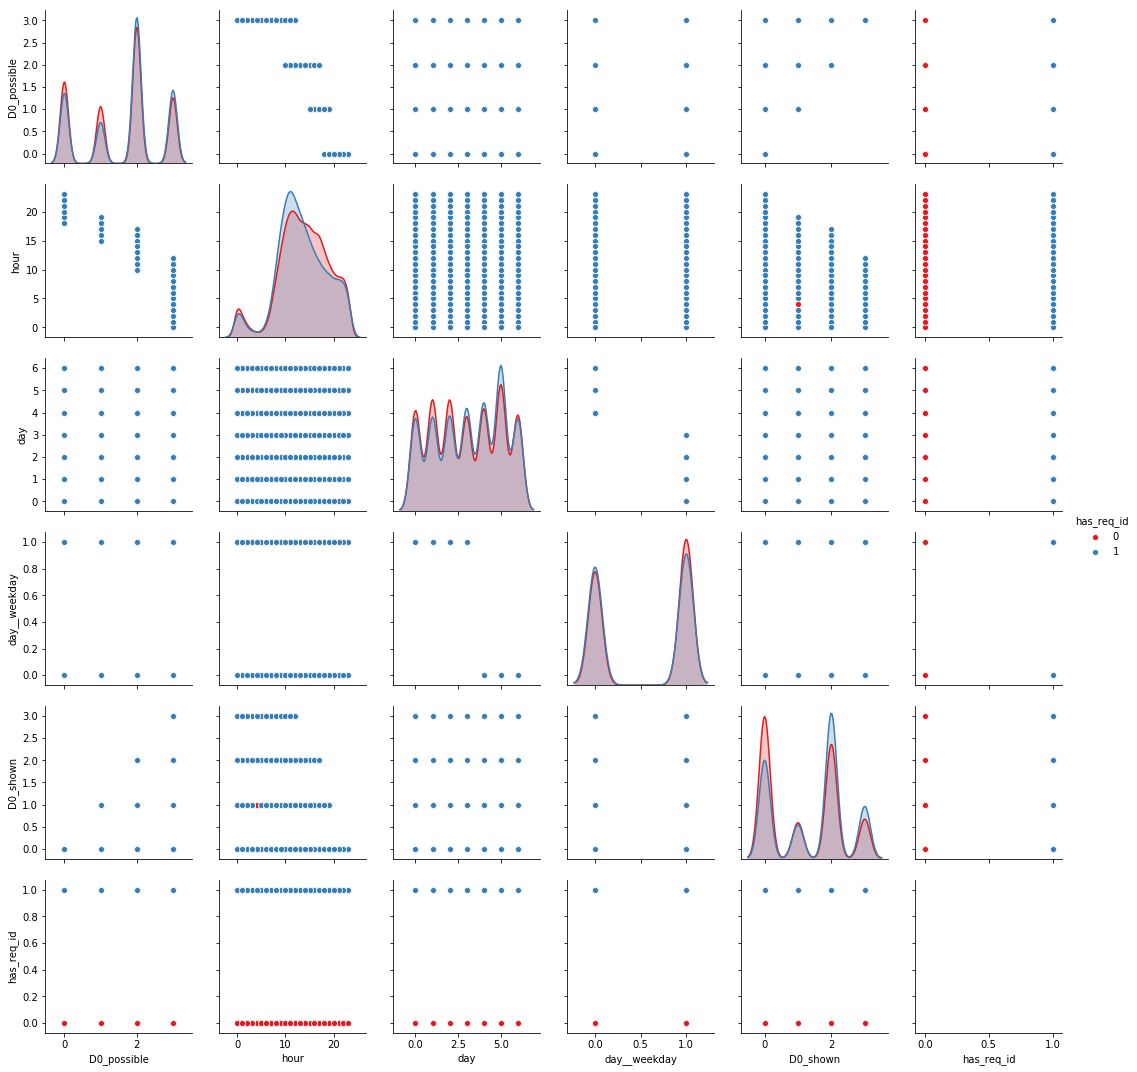

In [40]:
sample = train.sample(frac=0.05)
var = ['D0_possible', 'hour', 'day', 'day__weekday', 'D0_shown', 'has_req_id']
sample = sample[var]
sns.pairplot(sample,  hue='has_req_id', palette = 'Set1', diag_kind='kde')
plt.show()

In [41]:
train.drop('day__weekday',axis = 1 ,inplace = True)
test.drop('day__weekday',axis = 1 ,inplace = True)

In [42]:
id_test = test['record_id'].values
label_test = test['has_req_id'].values

target_train = train['has_req_id'].values

train = train.drop(['has_req_id','record_id'], axis = 1)
test = test.drop(['record_id','has_req_id'], axis = 1)

In [43]:
train.sample(5)

,hour,day,month,year,city__ahmedabad,city__bangalore,city__chandigarh,city__chennai,city__delhi,city__hyderabad,city__jaipur,city__kolkata,city__mumbai,city__pune,day__friday,day__saturday,day__sunday,cat__Appliance Repair,cat__Cleaning - Other,cat__EPC,cat__Full Home Cleaning,cat__Massage for Men,cat__Mens Grooming,cat__Pest Control,cat__Salon at Home,cat__Spa for Women,D0_possible,D0_shown,D1_shown,D2_shown
319883,22,5,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,2,3
315664,12,5,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,2,0,2,2
243627,15,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,2,2,3,3
144995,23,2,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3,3
610142,12,5,1,1,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,2,2,3,3


In [44]:
test.sample(5)

,hour,day,month,year,city__ahmedabad,city__bangalore,city__chandigarh,city__chennai,city__delhi,city__hyderabad,city__jaipur,city__kolkata,city__mumbai,city__pune,day__friday,day__saturday,day__sunday,cat__Appliance Repair,cat__Cleaning - Other,cat__EPC,cat__Full Home Cleaning,cat__Massage for Men,cat__Mens Grooming,cat__Pest Control,cat__Salon at Home,cat__Spa for Women,D0_possible,D0_shown,D1_shown,D2_shown
28277,12,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,2,2,3,3
135895,18,5,1,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,3,0
156807,13,6,1,1,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,2,2,3,3
152981,11,6,1,1,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,2,2,3,3
15901,19,0,1,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,3,3


# Training the model

In [45]:
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier 
Model = KNeighborsClassifier(n_neighbors=5) 
Model.fit(train, target_train) 
y_pred = Model.predict(test) # Summary of the predictions made by the classifier 
print('accuracy is',accuracy_score(y_pred,label_test))

accuracy is 0.5486860915145105


In [46]:
from sklearn.linear_model import LogisticRegression 
Model = LogisticRegression() 
Model.fit(train, target_train) 
y_pred = Model.predict(test)
print('accuracy is',accuracy_score(y_pred,label_test))

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


accuracy is 0.5777071396194837


In [47]:
from sklearn.naive_bayes import GaussianNB 
Model = GaussianNB() 
Model.fit(train, target_train) 
y_pred = Model.predict(test)
print('accuracy is',accuracy_score(y_pred,label_test))

accuracy is 0.5250694436373357


In [48]:
from sklearn.tree import DecisionTreeClassifier 
Model = DecisionTreeClassifier() 
Model.fit(train, target_train) 
y_pred = Model.predict(test)
print('accuracy is',accuracy_score(y_pred,label_test))

accuracy is 0.5609476877302682


In [49]:
from sklearn.ensemble import AdaBoostClassifier 
Model=AdaBoostClassifier() 
Model.fit(train, target_train) 
y_pred=Model.predict(test)
print('accuracy is ',accuracy_score(y_pred,label_test))

accuracy is  0.5802931160725701


In [50]:
from sklearn.ensemble import GradientBoostingClassifier 
Model=GradientBoostingClassifier() 
Model.fit(train, target_train) 
y_pred=Model.predict(test)
print('accuracy is ',accuracy_score(y_pred,label_test))

accuracy is  0.5852209992910357


/opt/conda/lib/python3.6/site-packages/sklearn/ensemble/forest.py:246: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


accuracy is  0.5675085133831546


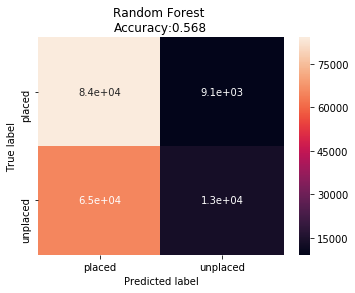

In [51]:
from sklearn.ensemble import RandomForestClassifier 
Model=RandomForestClassifier(max_depth=2) 
Model.fit(train, target_train) 
y_pred=Model.predict(test)
print('accuracy is ',accuracy_score(y_pred,label_test))

y_true = label_test
from sklearn.metrics import confusion_matrix
cm_dt = confusion_matrix(y_true,y_pred)
cm_df = pd.DataFrame(cm_dt,
                     index = ['placed','unplaced'], 
                     columns = ['placed','unplaced'])

plt.figure(figsize=(5.5,4))
sns.heatmap(cm_df, annot=True)
plt.title('Random Forest \nAccuracy:{0:.3f}'.format(accuracy_score(label_test, y_pred)))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

# Ensemble

**Ensable class for cross validation and ensamble**

Prepare an Ensamble class to split the data in **KFolds**, train the models and ensamble the results.

The class has an **init method** (called when an Ensamble object is created) that accepts 4 parameters:

* **self** - the object to be initialized
* **n_splits** - the number of cross-validation splits to be used
* **stacker** - the model used for stacking the prediction results from the trained base models
* **base_models** - the list of base models used in training

A second method, **fit_predict** has four functions:

* split the training data in n_splits folds;
* run the base models for each fold;
* perform prediction using each model;
* ensamble the resuls using the stacker;

In [52]:
class Ensemble(object):
    def __init__(self, n_splits, stacker, base_models):
        self.n_splits = n_splits
        self.stacker = stacker
        self.base_models = base_models

    def fit_predict(self, X, y, T):
        X = np.array(X)
        y = np.array(y)
        T = np.array(T)

        folds = list(StratifiedKFold(n_splits=self.n_splits, shuffle=True, random_state=314).split(X, y))

        S_train = np.zeros((X.shape[0], len(self.base_models)))
        S_test = np.zeros((T.shape[0], len(self.base_models)))
        for i, clf in enumerate(self.base_models):

            S_test_i = np.zeros((T.shape[0], self.n_splits))

            for j, (train_idx, test_idx) in enumerate(folds):
                X_train = X[train_idx]
                y_train = y[train_idx]
                X_holdout = X[test_idx]


                print ("Base model %d: fit %s model | fold %d" % (i+1, str(clf).split('(')[0], j+1))
                clf.fit(X_train, y_train)
                cross_score = cross_val_score(clf, X_train, y_train, cv=3, scoring='roc_auc')
                print("cross_score [roc-auc]: %.5f [gini]: %.5f" % (cross_score.mean(), 2*cross_score.mean()-1))
                y_pred = clf.predict_proba(X_holdout)[:,1]                

                S_train[test_idx, i] = y_pred
                S_test_i[:, j] = clf.predict_proba(T)[:,1]
            S_test[:, i] = S_test_i.mean(axis=1)

        results = cross_val_score(self.stacker, S_train, y, cv=3, scoring='roc_auc')
        # Calculate gini factor as 2 * AUC - 1
        print("Stacker score [gini]: %.5f" % (2 * results.mean() - 1))

        self.stacker.fit(S_train, y)
        res = self.stacker.predict_proba(S_test)[:,1]
        return res

**Parameters for the base models**

For the base models, we prepare three different LightGBM models and one XGB model.

Each model is used to train the data (using as well cross-validation, with 3 folds).

In [53]:
# LightGBM params
# lgb_1
lgb_params1 = {}
lgb_params1['learning_rate'] = 0.02
lgb_params1['n_estimators'] = 650
lgb_params1['max_bin'] = 10
lgb_params1['subsample'] = 0.8
lgb_params1['subsample_freq'] = 10
lgb_params1['colsample_bytree'] = 0.8   
lgb_params1['min_child_samples'] = 500
lgb_params1['seed'] = 314
lgb_params1['num_threads'] = 4

# lgb2
lgb_params2 = {}
lgb_params2['n_estimators'] = 1090
lgb_params2['learning_rate'] = 0.02
lgb_params2['colsample_bytree'] = 0.3   
lgb_params2['subsample'] = 0.7
lgb_params2['subsample_freq'] = 2
lgb_params2['num_leaves'] = 16
lgb_params2['seed'] = 314
lgb_params2['num_threads'] = 4

# lgb3
lgb_params3 = {}
lgb_params3['n_estimators'] = 1100
lgb_params3['max_depth'] = 4
lgb_params3['learning_rate'] = 0.02
lgb_params3['seed'] = 314
lgb_params3['num_threads'] = 4

# XGBoost params
xgb_params = {}
xgb_params['objective'] = 'binary:logistic'
xgb_params['learning_rate'] = 0.04
xgb_params['n_estimators'] = 490
xgb_params['max_depth'] = 4
xgb_params['subsample'] = 0.9
xgb_params['colsample_bytree'] = 0.9  
xgb_params['min_child_weight'] = 10
xgb_params['num_threads'] = 4

**Initialize the models with the parameters**

We init the 3 base models and the stacking model. For the base models we are using the predefined parameters initialized above.

In [54]:
# Base models
lgb_model1 = LGBMClassifier(**lgb_params1)
lgb_model2 = LGBMClassifier(**lgb_params2)
lgb_model3 = LGBMClassifier(**lgb_params3)
xgb_model = XGBClassifier(**xgb_params)

# Stacking model
log_model = LogisticRegression()

In [55]:
stack = Ensemble(n_splits=3,stacker = log_model, base_models = (lgb_model1, lgb_model2, lgb_model3, xgb_model))  

In [56]:
y_prediction = stack.fit_predict(train, target_train, test) 
y_prediction

Base model 1: fit LGBMClassifier model | fold 1
cross_score [roc-auc]: 0.62209 [gini]: 0.24418
Base model 1: fit LGBMClassifier model | fold 2
cross_score [roc-auc]: 0.62180 [gini]: 0.24360
Base model 1: fit LGBMClassifier model | fold 3
cross_score [roc-auc]: 0.62154 [gini]: 0.24308
Base model 2: fit LGBMClassifier model | fold 1
cross_score [roc-auc]: 0.62512 [gini]: 0.25024
Base model 2: fit LGBMClassifier model | fold 2
cross_score [roc-auc]: 0.62516 [gini]: 0.25033
Base model 2: fit LGBMClassifier model | fold 3
cross_score [roc-auc]: 0.62458 [gini]: 0.24917
Base model 3: fit LGBMClassifier model | fold 1
cross_score [roc-auc]: 0.62428 [gini]: 0.24857
Base model 3: fit LGBMClassifier model | fold 2
cross_score [roc-auc]: 0.62439 [gini]: 0.24878
Base model 3: fit LGBMClassifier model | fold 3
cross_score [roc-auc]: 0.62354 [gini]: 0.24708
Base model 4: fit XGBClassifier model | fold 1
cross_score [roc-auc]: 0.62418 [gini]: 0.24837
Base model 4: fit XGBClassifier model | fold 2
cros

/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Stacker score [gini]: 0.26676


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


array([0.41617317, 0.45965775, 0.36618982, ..., 0.45920325, 0.47656284,
       0.43938677])

In [57]:
for i in range(len(y_prediction)):
    if y_prediction[i]<0.5:
        y_prediction[i]=0
    else:
        y_prediction[i]=1
        
print('accuracy with ensemble is',accuracy_score(y_prediction,label_test))

accuracy with ensemble is 0.5856684603851652
